# Setup

Use the steady state frames, used in the paper describing the methods. Also uses roughly the same style in the plots.

In [1]:
steady_states = {
    "uo-050-180-180": [211, 800],
    "uo-060-180-180": [243, 771],
    "uo-070-180-180": [203, 1113],
    "uo-100-180-180": [200, 790],
    "uo-145-180-180": [300, 1097],
    "uo-180-180-070": [500, 1399],
    "uo-180-180-095": [400, 1350],
    "uo-180-180-120": [300, 1099],
    "uo-180-180-180": [400, 1284],
}

style_options = {
    "uo-050-180-180": {"color": "red", "marker": "+"},
    "uo-060-180-180": {"color": "green", "marker": "x"},
    "uo-070-180-180": {"color": "blue", "marker": "x"},
    "uo-100-180-180": {"color": "white", "marker": "s", "edgecolors": "pink"},
    "uo-145-180-180": {"color": "cyan", "marker": "s"},
    "uo-180-180-070": {"color": "grey", "marker": "^"},
    "uo-180-180-095": {"color": "white", "marker": "^", "edgecolors": "orange"},
    "uo-180-180-120": {
        "color": "black",
        "marker": "o",
    },
    "uo-180-180-180": {"color": "white", "marker": "o", "edgecolors": "purple"},
}

## Load trajectories

In [2]:
import pathlib
from pedpy import load_trajectory, TrajectoryUnit, TrajectoryData

folder = pathlib.Path("demo-data/uni-directional")
trajectories = {}
trajectories_in_steady_state = {}
for file in folder.glob("uo*.txt"):
    trajectory = load_trajectory(
        trajectory_file=file,
        default_frame_rate=16.0,
        default_unit=TrajectoryUnit.CENTIMETER,
    )
    trajectory_in_steady_state = TrajectoryData(
        data=trajectory.data[
            trajectory.data.frame.between(
                steady_states[file.stem][0], steady_states[file.stem][1]
            )
        ],
        frame_rate=trajectory.frame_rate,
    )

    trajectories[file.stem] = trajectory
    trajectories_in_steady_state[file.stem] = trajectory_in_steady_state

## Define geometry

In [3]:
from shapely import Polygon
from pedpy import WalkableArea

walkable_area = WalkableArea(
    Polygon(
        [
            (2.8, -6.5),
            (2.8, -4),
            (1.8, -4),
            (1.8, 4),
            (2.8, 4),
            (2.8, 8),
            (-1, 8),
            (-1, 4),
            (0, 4),
            (0, -4),
            (-1, -4),
            (-1, -6.5),
        ]
    )
)

## Define measurement areas and lines

In [4]:
from pedpy import MeasurementLine, MeasurementArea

measurement_area = MeasurementArea([(0, -2), (0, 0), (1.8, 0), (1.8, -2)])
measurement_line = MeasurementLine([(0, 0), (1.8, 0)])

## Plot trajectories, geometry, and measurement areas/lines

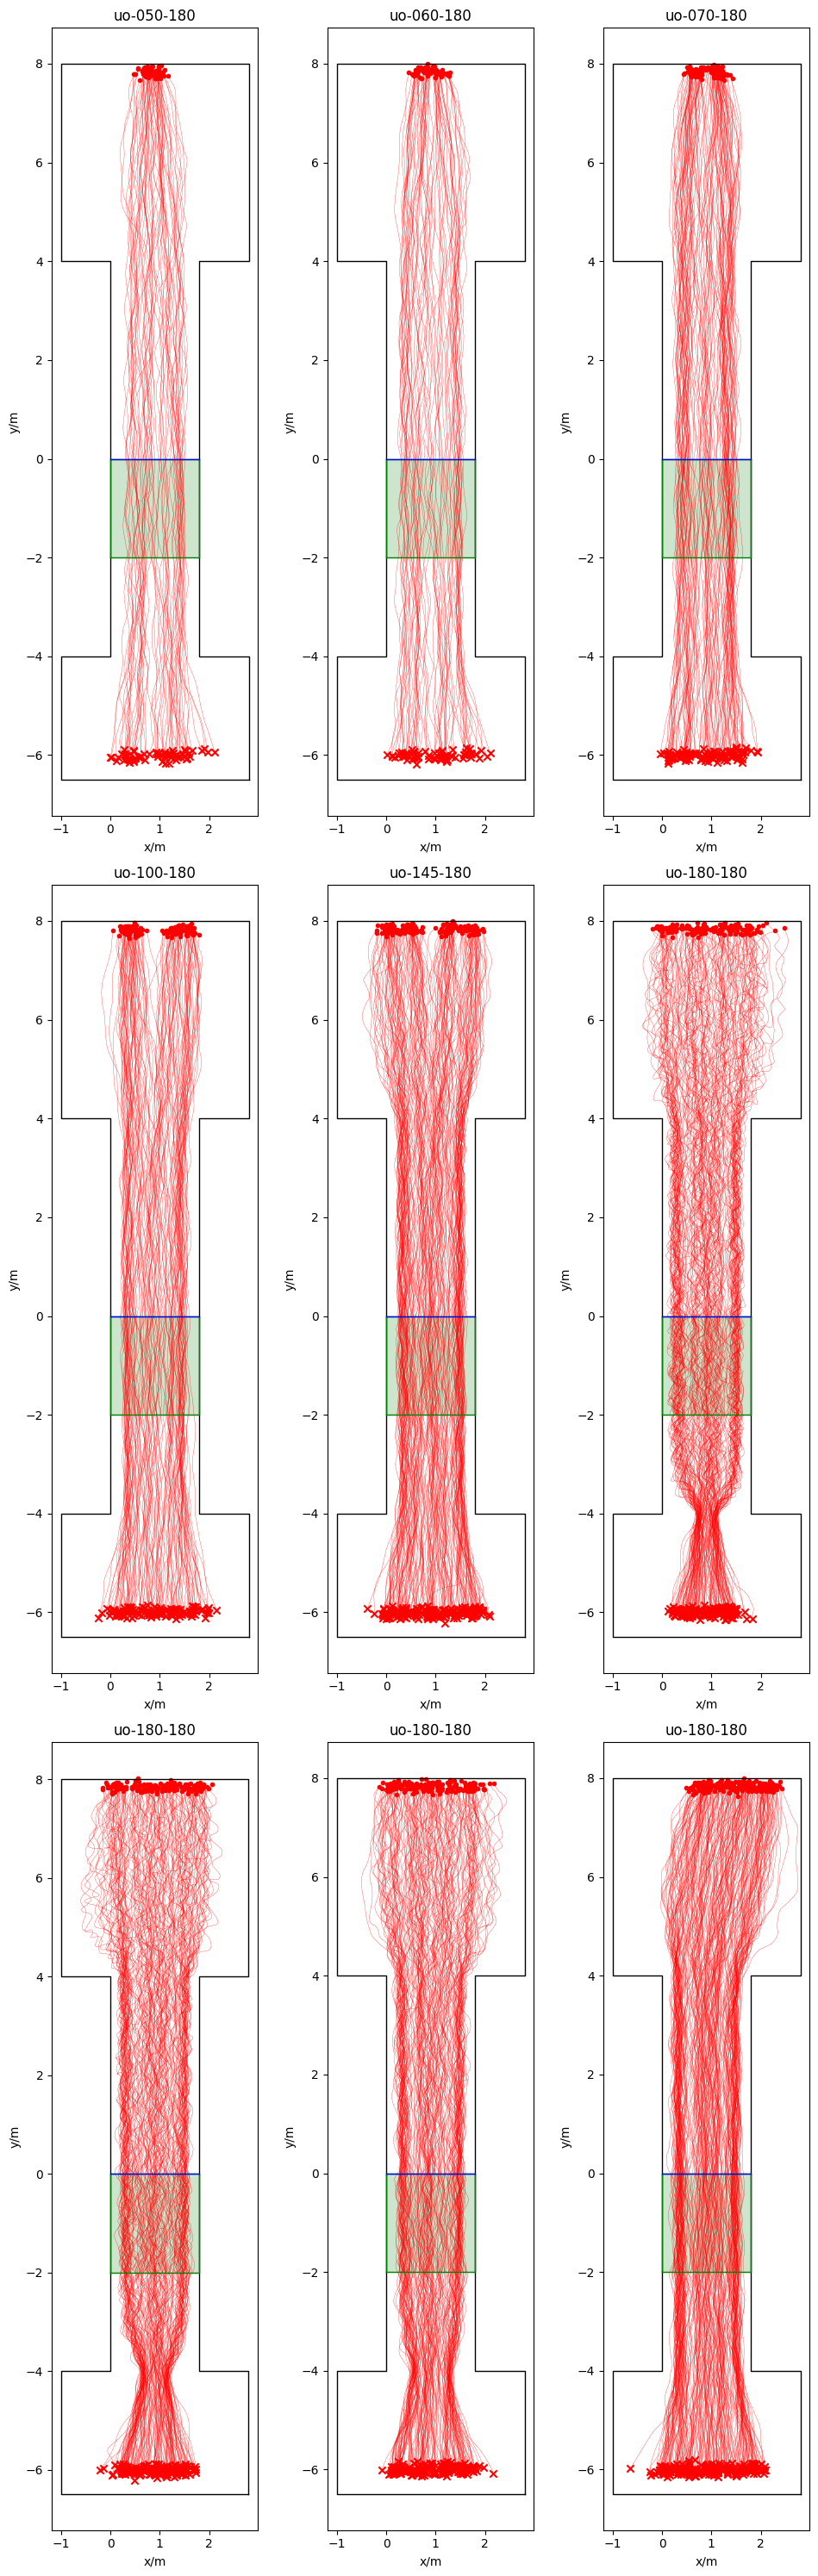

In [5]:
import matplotlib.pyplot as plt
from pedpy import plot_measurement_setup

fig, axs = plt.subplots(3, int(len(trajectories) / 3), figsize=(10, 30))

for (name, trajectory), ax in zip(trajectories.items(), axs.ravel()):
    ax.set_title(name[:-4])

    ax = plot_measurement_setup(
        traj=trajectory,
        walkable_area=walkable_area,
        measurement_areas=[measurement_area],
        measurement_lines=[measurement_line],
        ax=ax,
        traj_width=0.2,
        traj_start_marker=".",
        traj_end_marker="x",
        ma_color="g",
        ma_line_color="g",
        ma_alpha=0.2,
        ml_color="b",
    )
    ax.set_aspect("equal")

fig.tight_layout()
plt.show()

In [6]:
from pedpy.column_identifier import *

# Method A

## Compute n-t and flow

In [7]:
from pedpy import (
    compute_n_t,
    compute_flow,
    compute_individual_speed,
    SpeedBorderMethod,
)

nts = {}
flows = {}

for name, trajectory in trajectories.items():
    individual_speed = compute_individual_speed(
        traj_data=trajectories_in_steady_state[name],
        frame_step=10,
        speed_border_method=SpeedBorderMethod.SINGLE_SIDED,
    )

    nt, crossing = compute_n_t(
        traj_data=trajectories_in_steady_state[name],
        measurement_line=measurement_line,
    )

    delta_frame = int(10 * trajectory.frame_rate)
    flow = compute_flow(
        nt=nt,
        crossing_frames=crossing,
        individual_speed=individual_speed,
        delta_frame=delta_frame,
        frame_rate=trajectory.frame_rate,
    )

    flows[name] = flow
    nts[name] = nt

## Plot n-t diagram

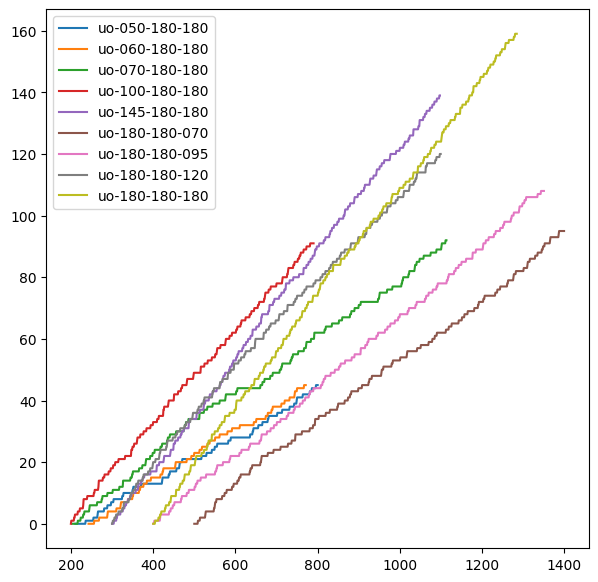

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(111)

for name, nt in nts.items():
    ax1.plot(nt.index, nt.cumulative_pedestrians, label=name)

ax1.legend()
plt.show()

## Plot fundamental diagram

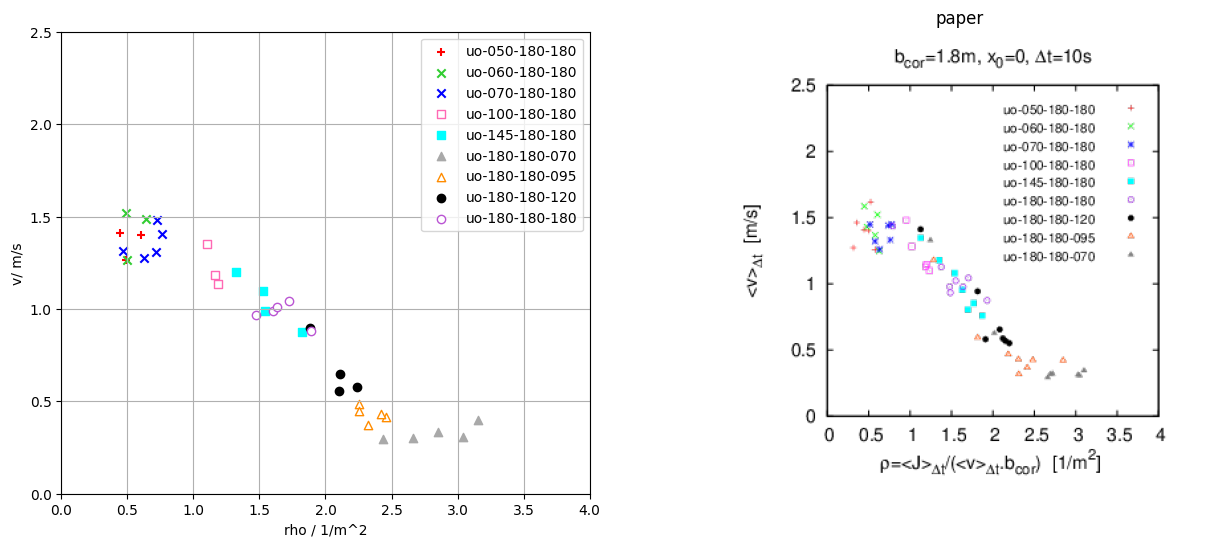

In [9]:
import matplotlib.pyplot as plt
from matplotlib import image as mpimg

style_options = {
    "uo-050-180-180": {"color": "red", "marker": "+"},
    "uo-060-180-180": {"color": "limegreen", "marker": "x"},
    "uo-070-180-180": {"color": "blue", "marker": "x"},
    "uo-100-180-180": {
        "color": "white",
        "marker": "s",
        "edgecolors": "hotpink",
    },
    "uo-145-180-180": {"color": "cyan", "marker": "s"},
    "uo-180-180-070": {"color": "darkgrey", "marker": "^"},
    "uo-180-180-095": {
        "color": "white",
        "marker": "^",
        "edgecolors": "darkorange",
    },
    "uo-180-180-120": {
        "color": "black",
        "marker": "o",
    },
    "uo-180-180-180": {
        "color": "white",
        "marker": "o",
        "edgecolors": "mediumorchid",
    },
}

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

for name, flow in flows.items():
    ax0.scatter(
        flow[FLOW_COL] / (flow[MEAN_SPEED_COL] * measurement_line.length),
        flow[MEAN_SPEED_COL],
        label=name,
        **style_options[name],
    )

ax0.set_xlim(left=0, right=4)
ax0.set_ylim(bottom=0, top=2.5)

ax0.set_xlabel("rho / 1/m^2")
ax0.set_ylabel("v/ m/s")
ax0.grid()
ax0.legend()

img = mpimg.imread(folder / "comparison/method_a_uo.png")
ax1.set_title("paper")
ax1.imshow(img)
ax1.axis("off")

plt.show()

# Method B

## Compute individual speed and density while passing the measurement area

In [10]:
from pedpy import (
    compute_passing_speed,
    compute_passing_density,
    compute_classic_density,
    compute_frame_range_in_area,
)

passing_densities = {}
passing_speeds = {}

for name, trajectory in trajectories.items():
    frames_in_area, passing_area = compute_frame_range_in_area(
        traj_data=trajectories_in_steady_state[name],
        measurement_line=measurement_line,
        width=2,
    )

    passing_speed = compute_passing_speed(
        frames_in_area=frames_in_area,
        frame_rate=trajectory.frame_rate,
        distance=2.0,
    )

    density_per_frame = compute_classic_density(
        traj_data=trajectories_in_steady_state[name],
        measurement_area=passing_area,
    )
    passing_density = compute_passing_density(
        density_per_frame=density_per_frame, frames=frames_in_area
    )

    passing_speeds[name] = passing_speed
    passing_densities[name] = passing_density

## Plot fundamental diagram

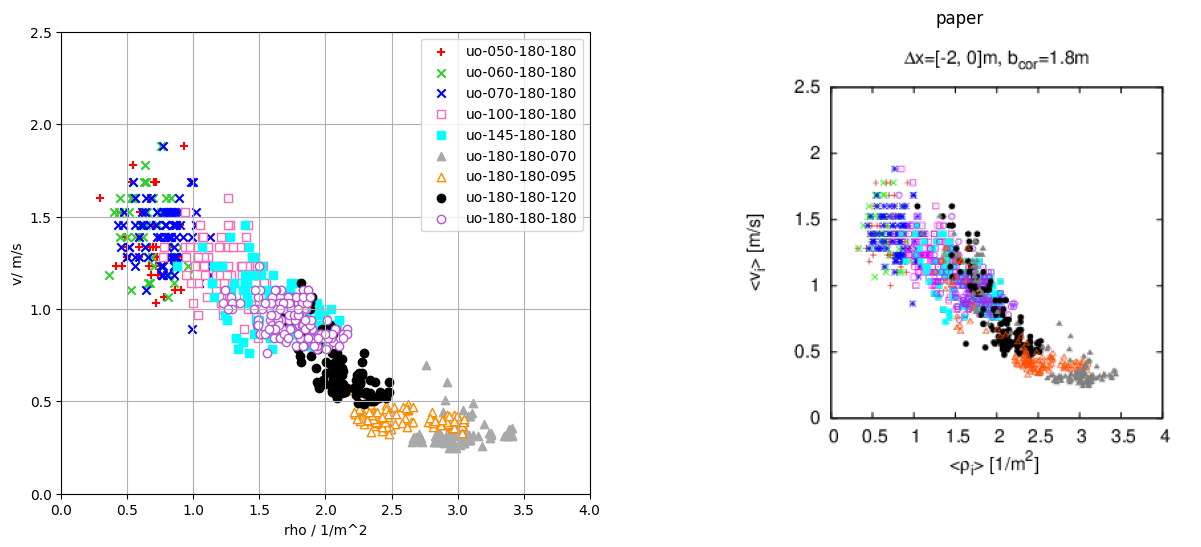

In [11]:
import matplotlib.pyplot as plt
from matplotlib import image as mpimg

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

for name in passing_speeds.keys():
    ax0.scatter(
        passing_densities[name][DENSITY_COL],
        passing_speeds[name][SPEED_COL],
        label=name,
        **style_options[name],
    )
ax0.set_xlim(left=0, right=4)
ax0.set_ylim(bottom=0, top=2.5)

ax0.set_xlabel("rho / 1/m^2")
ax0.set_ylabel("v/ m/s")
ax0.grid()
ax0.legend()

img = mpimg.imread(folder / "comparison/method_b_uo.png")
ax1.set_title("paper")
ax1.imshow(img)
ax1.axis("off")

plt.show()

# Method C

## Compute density and speed

In [12]:
from pedpy import (
    compute_classic_density,
    compute_mean_speed_per_frame,
    SpeedBorderMethod,
)

classic_densities = {}
mean_area_speeds = {}

for name, trajectory in trajectories.items():
    individual_speed = compute_individual_speed(
        traj_data=trajectories_in_steady_state[name],
        frame_step=5,
        speed_border_method=SpeedBorderMethod.SINGLE_SIDED,
    )
    mean_area_speed = compute_mean_speed_per_frame(
        traj_data=trajectories_in_steady_state[name],
        measurement_area=measurement_area,
        individual_speed=individual_speed,
    )

    classic_density = compute_classic_density(
        traj_data=trajectories_in_steady_state[name],
        measurement_area=measurement_area,
    )

    classic_densities[name] = classic_density
    mean_area_speeds[name] = mean_area_speed

## Plot time series data

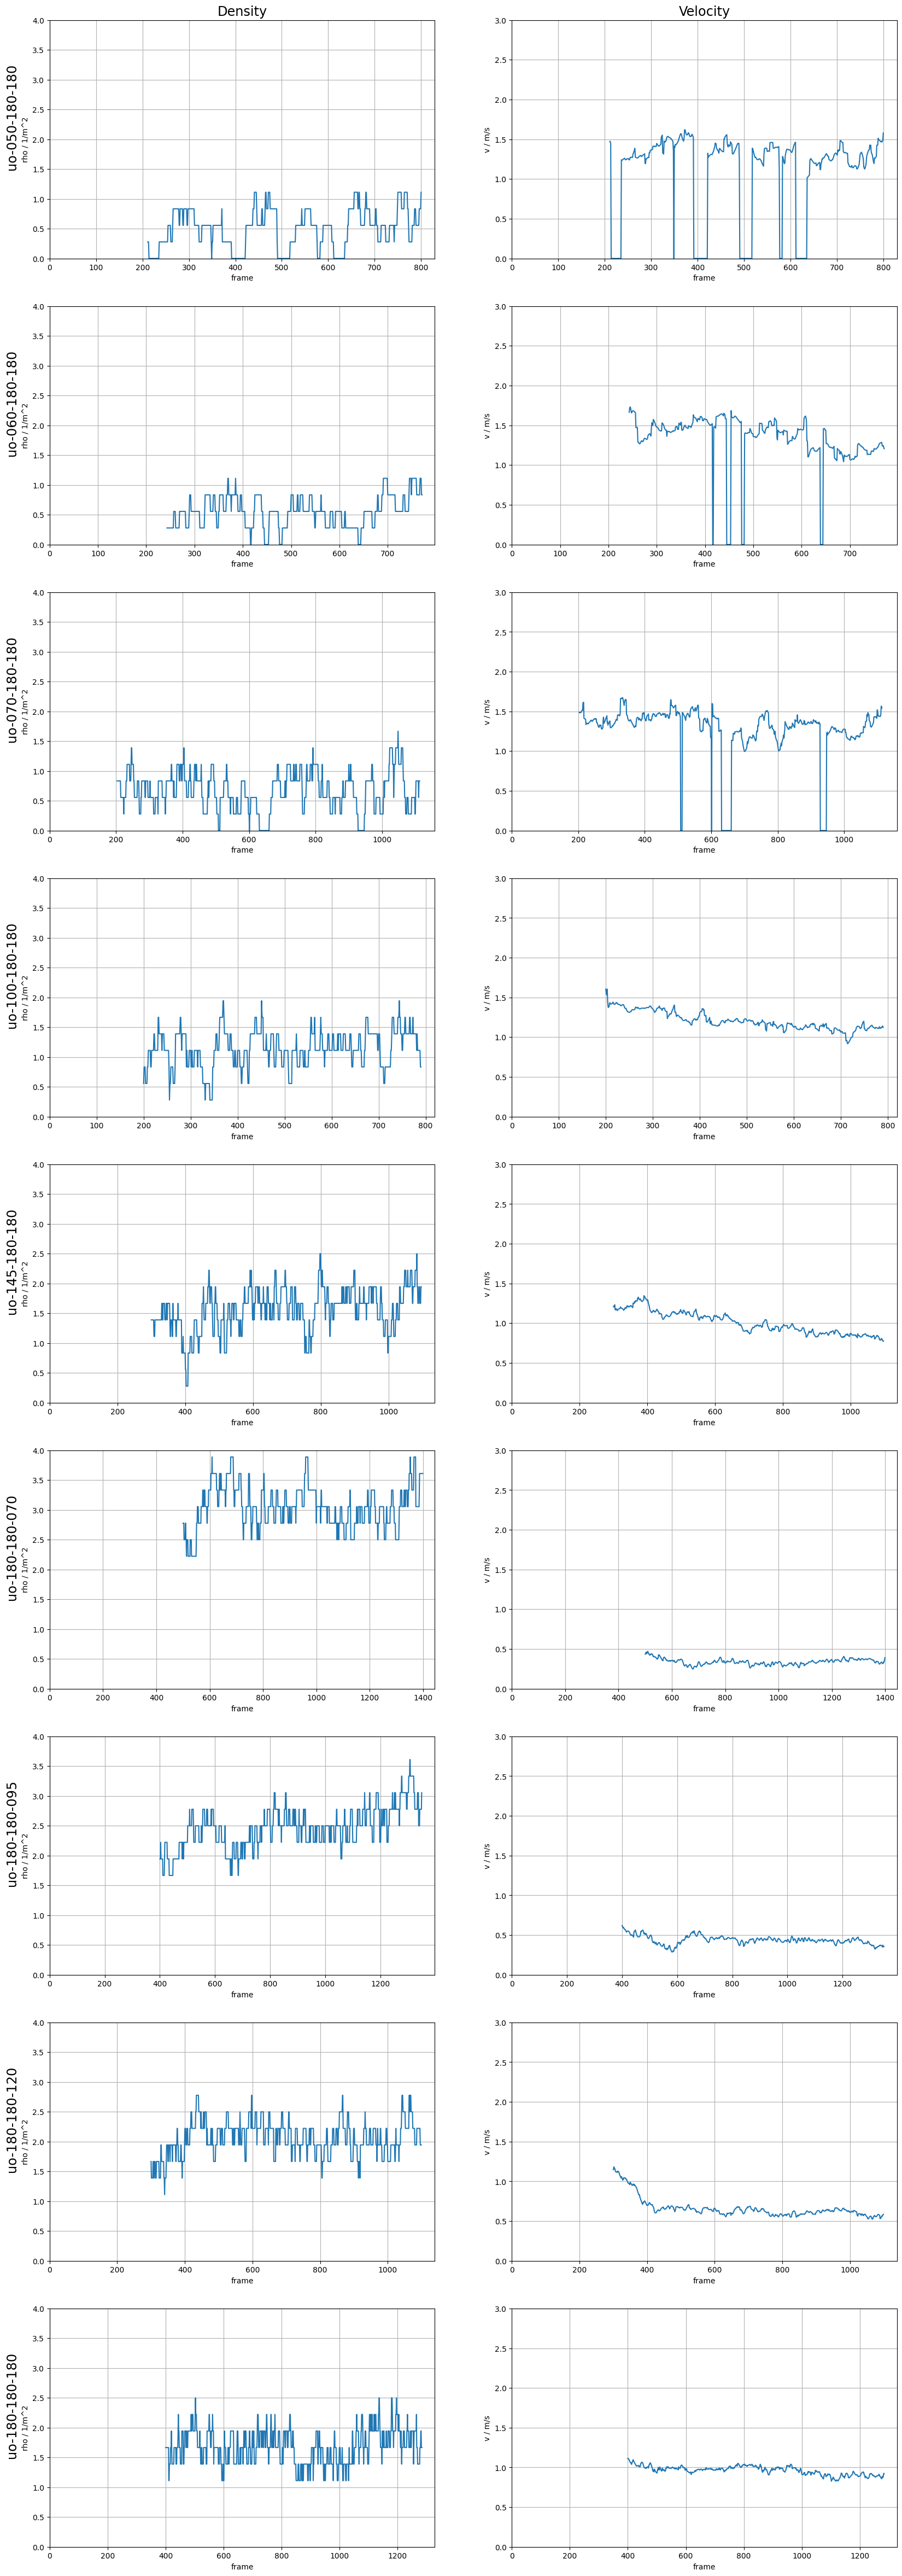

In [13]:
fig, ax = plt.subplots(
    nrows=len(trajectories.values()), ncols=2, figsize=(20, 60)
)
row = 0

ax[row, 1].set_title("Velocity", size="xx-large")
ax[row, 0].set_title("Density", size="xx-large")

for name, trajectory in trajectories.items():
    ax[row, 0].annotate(
        name,
        xy=(0.5, 1),
        xytext=(-ax[row, 0].yaxis.labelpad - 5, 0),
        xycoords=ax[row, 0].yaxis.label,
        textcoords="offset points",
        size="xx-large",
        ha="right",
        va="center",
        rotation=90,
    )

    ax[row, 0].plot(
        classic_densities[name].index,
        classic_densities[name][DENSITY_COL],
        alpha=1,
    )
    ax[row, 0].set_xlim(left=0)
    ax[row, 0].set_ylim(bottom=0, top=4)
    ax[row, 0].set_xlabel("frame")
    ax[row, 0].set_ylabel("rho / 1/m^2")
    ax[row, 0].grid()

    ax[row, 1].plot(
        mean_area_speeds[name].index, mean_area_speeds[name], alpha=1
    )
    ax[row, 1].set_xlim(
        left=0,
    )
    ax[row, 1].set_ylim(bottom=0, top=3)
    ax[row, 1].set_xlabel("frame")
    ax[row, 1].set_ylabel("v / m/s")
    ax[row, 1].grid()

    row += 1

## Plot fundamental diagram

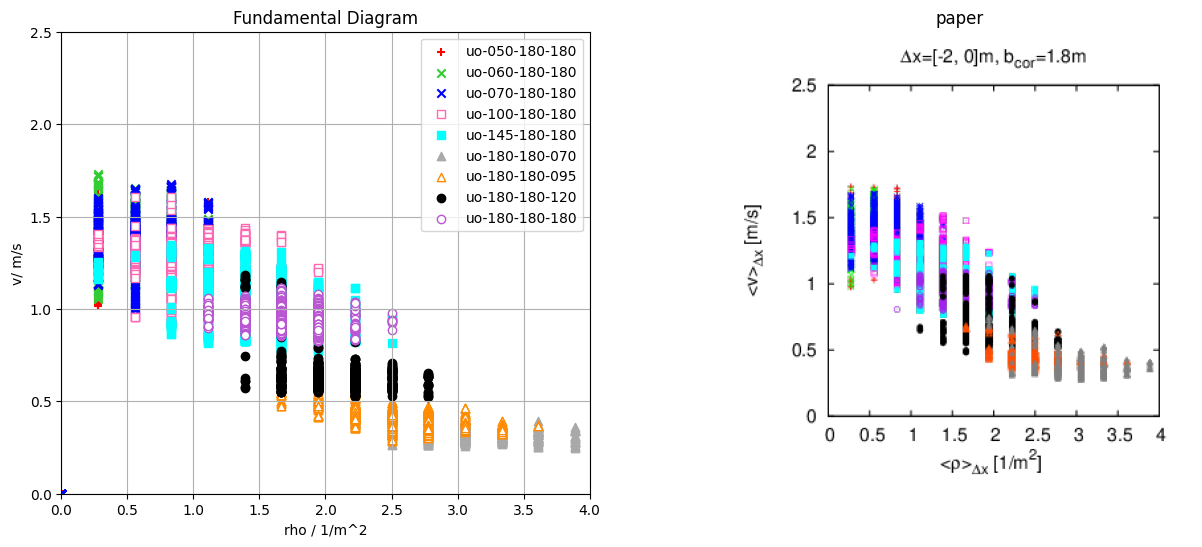

In [14]:
import matplotlib.pyplot as plt
from matplotlib import image as mpimg

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax0.set_title("Fundamental Diagram")

for name in classic_densities.keys():
    ax0.scatter(
        classic_densities[name][DENSITY_COL],
        mean_area_speeds[name],
        alpha=1,
        label=name,
        **style_options[name],
    )
ax0.set_xlim(left=0, right=4)
ax0.set_ylim(bottom=0, top=2.5)

ax0.set_xlabel("rho / 1/m^2")
ax0.set_ylabel("v/ m/s")
ax0.grid()
ax0.legend()

img = mpimg.imread(folder / "comparison/method_c_uo.png")
ax1.set_title("paper")
ax1.imshow(img)
ax1.axis("off")
plt.show()

# Method D

## Compute density and speed

### Without cutoff radius

In [15]:
from pedpy import (
    compute_voronoi_speed,
    compute_voronoi_density,
    compute_individual_voronoi_polygons,
    SpeedBorderMethod,
)

voronoi_densities = {}
voronoi_speeds = {}
individual_speeds = {}
individuals = {}

for name, trajectory in trajectories.items():
    individual = compute_individual_voronoi_polygons(
        traj_data=trajectories_in_steady_state[name],
        walkable_area=walkable_area,
    )
    voronoi_density, intersecting = compute_voronoi_density(
        individual_voronoi_data=individual,
        measurement_area=measurement_area,
    )

    individual_speed = compute_individual_speed(
        traj_data=trajectories_in_steady_state[name],
        frame_step=5,
        speed_border_method=SpeedBorderMethod.SINGLE_SIDED,
    )
    voronoi_speed = compute_voronoi_speed(
        traj_data=trajectories_in_steady_state[name],
        individual_voronoi_intersection=intersecting,
        measurement_area=measurement_area,
        individual_speed=individual_speed,
    )

    voronoi_densities[name] = voronoi_density
    voronoi_speeds[name] = voronoi_speed
    individual_speeds[name] = individual_speed
    individuals[name] = intersecting

/home/tobias/dev/pedpy/pedpy-venv/lib64/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in intersection
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tobias/dev/pedpy/pedpy-venv/lib64/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in intersection
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tobias/dev/pedpy/pedpy-venv/lib64/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in intersection
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tobias/dev/pedpy/pedpy-venv/lib64/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in intersection
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tobias/dev/pedpy/pedpy-venv/lib64/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in intersection
  result = getattr(ufun

### With cutoff radius

In [16]:
from pedpy import (
    compute_voronoi_speed,
    compute_voronoi_density,
    Cutoff,
    SpeedBorderMethod,
)

voronoi_densities_cutoff = {}
voronoi_speeds_cutoff = {}
individual_speeds_cutoff = {}
individual_cutoffs = {}
for name, trajectory in trajectories.items():
    individual_cutoff = compute_individual_voronoi_polygons(
        traj_data=trajectories_in_steady_state[name],
        walkable_area=walkable_area,
        cut_off=Cutoff(radius=0.8, quad_segments=3),
    )
    voronoi_density_cutoff, intersecting_cutoff = compute_voronoi_density(
        individual_voronoi_data=individual_cutoff,
        measurement_area=measurement_area,
    )

    individual_speed = compute_individual_speed(
        traj_data=trajectories_in_steady_state[name],
        frame_step=5,
        speed_border_method=SpeedBorderMethod.SINGLE_SIDED,
    )

    voronoi_speed_cutoff = compute_voronoi_speed(
        traj_data=trajectories_in_steady_state[name],
        individual_voronoi_intersection=intersecting_cutoff,
        individual_speed=individual_speed,
        measurement_area=measurement_area,
    )

    voronoi_densities_cutoff[name] = voronoi_density_cutoff
    voronoi_speeds_cutoff[name] = voronoi_speed_cutoff
    individual_speeds_cutoff[name] = individual_speed
    individual_cutoffs[name] = intersecting_cutoff

/home/tobias/dev/pedpy/pedpy-venv/lib64/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in intersection
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tobias/dev/pedpy/pedpy-venv/lib64/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in intersection
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tobias/dev/pedpy/pedpy-venv/lib64/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in intersection
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tobias/dev/pedpy/pedpy-venv/lib64/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in intersection
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tobias/dev/pedpy/pedpy-venv/lib64/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in intersection
  result = getattr(ufun

## Plot time-series data

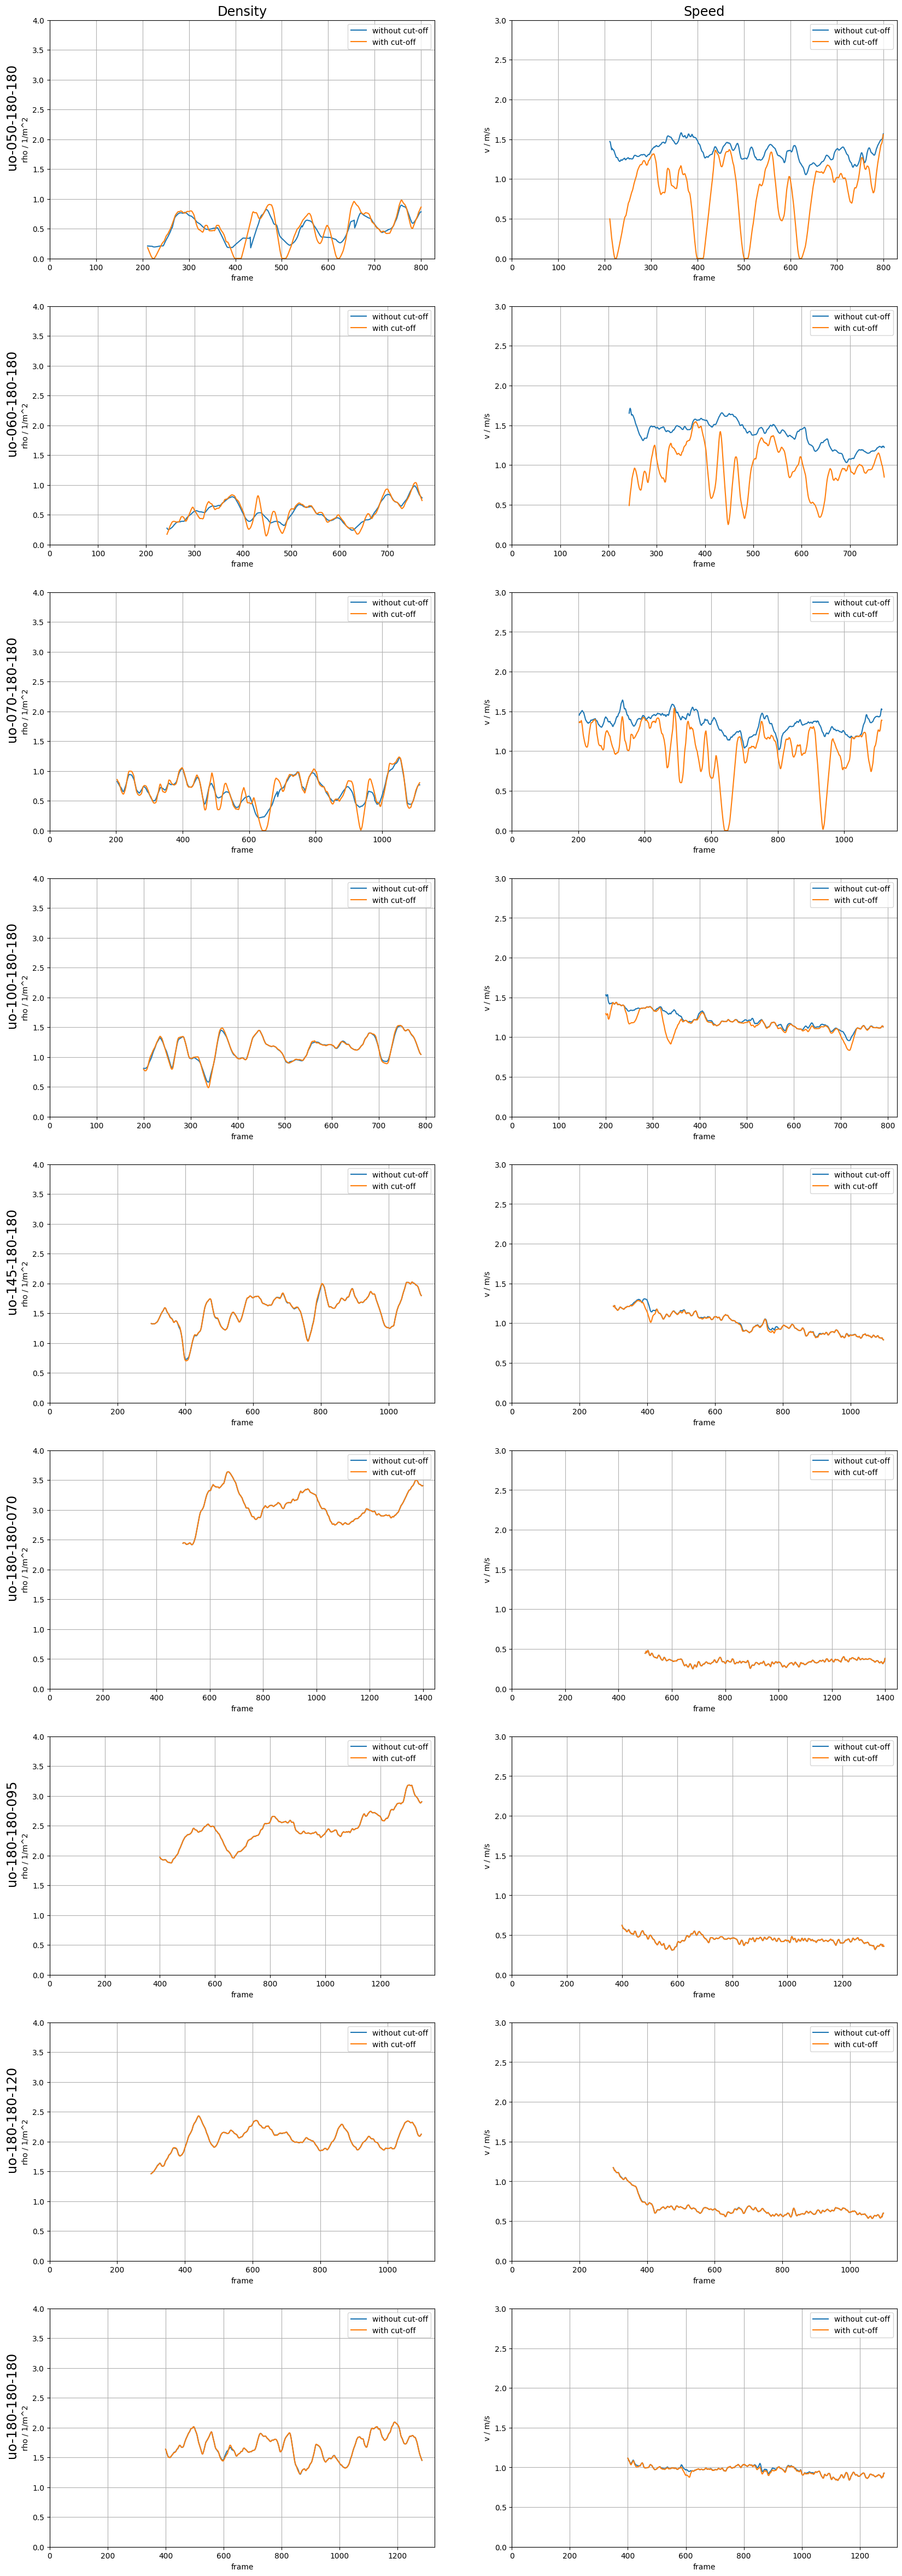

In [17]:
fig, ax = plt.subplots(
    nrows=len(trajectories.values()), ncols=2, figsize=(20, 60)
)
row = 0

ax[row, 1].set_title("Speed", size="xx-large")
ax[row, 0].set_title("Density", size="xx-large")

for name, trajectory in trajectories.items():
    ax[row, 0].annotate(
        name,
        xy=(0.5, 1),
        xytext=(-ax[row, 0].yaxis.labelpad - 5, 0),
        xycoords=ax[row, 0].yaxis.label,
        textcoords="offset points",
        size="xx-large",
        ha="right",
        va="center",
        rotation=90,
    )

    ax[row, 0].plot(
        voronoi_densities[name].index,
        voronoi_densities[name][DENSITY_COL],
        alpha=1,
        label="without cut-off",
    )
    ax[row, 0].plot(
        voronoi_densities_cutoff[name].index,
        voronoi_densities_cutoff[name][DENSITY_COL],
        alpha=1,
        label="with cut-off",
    )
    ax[row, 0].set_xlim(left=0)
    ax[row, 0].set_ylim(bottom=0, top=4)
    ax[row, 0].set_xlabel("frame")
    ax[row, 0].set_ylabel("rho / 1/m^2")
    ax[row, 0].grid()
    ax[row, 0].legend()

    ax[row, 1].plot(
        voronoi_speeds[name].index,
        voronoi_speeds[name],
        alpha=1,
        label="without cut-off",
    )
    ax[row, 1].plot(
        voronoi_speeds_cutoff[name].index,
        voronoi_speeds_cutoff[name],
        alpha=1,
        label="with cut-off",
    )
    ax[row, 1].set_xlim(
        left=0,
    )
    ax[row, 1].set_ylim(bottom=0, top=3)
    ax[row, 1].set_xlabel("frame")
    ax[row, 1].set_ylabel("v / m/s")
    ax[row, 1].grid()
    ax[row, 1].legend()
    row += 1
plt.show()

## Plot fundamental diagram

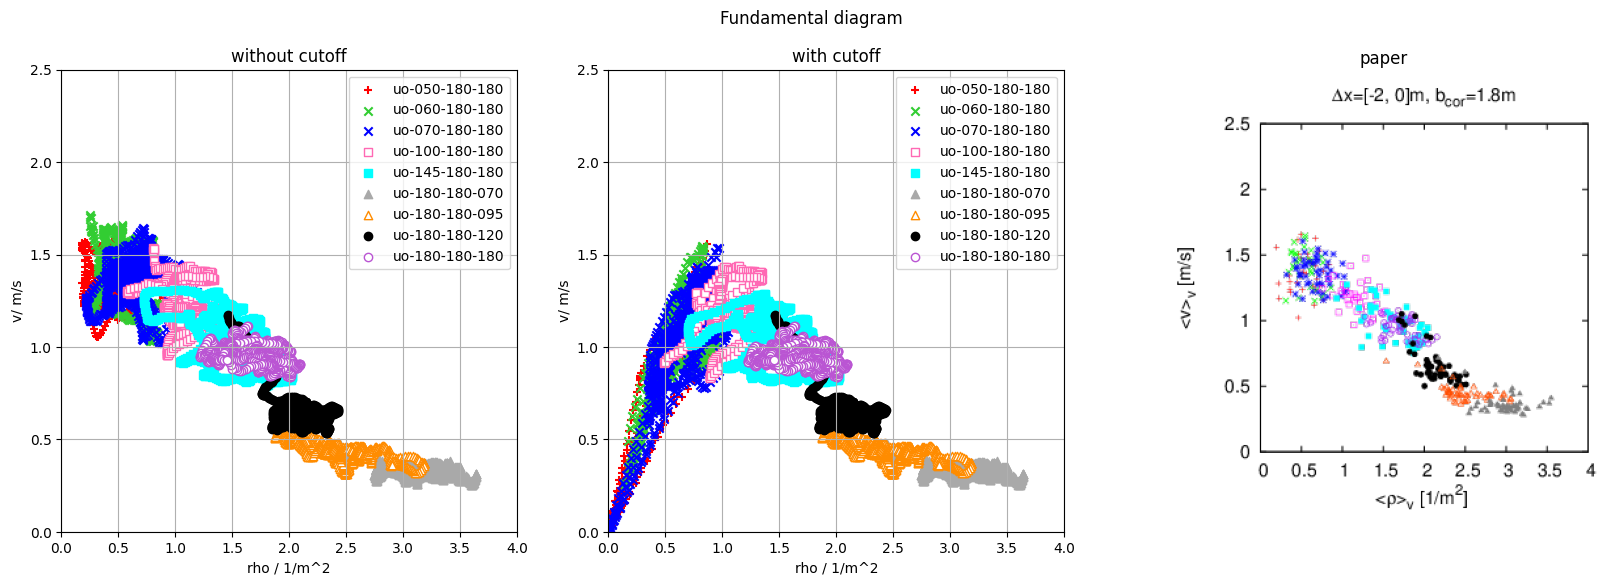

In [18]:
from matplotlib import image as mpimg
import matplotlib.pyplot as plt

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
fig.suptitle("Fundamental diagram")

ax0.set_title("without cutoff")
for name in voronoi_densities.keys():
    ax0.scatter(
        voronoi_densities[name][DENSITY_COL],
        voronoi_speeds[name],
        alpha=1,
        label=name,
        **style_options[name],
    )
ax0.set_xlim(left=0, right=4)
ax0.set_ylim(bottom=0, top=2.5)

ax0.set_xlabel("rho / 1/m^2")
ax0.set_ylabel("v/ m/s")
ax0.grid()
ax0.legend()

ax1.set_title("with cutoff")
for name in voronoi_densities_cutoff.keys():
    ax1.scatter(
        voronoi_densities_cutoff[name][DENSITY_COL],
        voronoi_speeds_cutoff[name],
        alpha=1,
        label=name,
        **style_options[name],
    )
ax1.set_xlim(left=0, right=4)
ax1.set_ylim(bottom=0, top=2.5)

ax1.set_xlabel("rho / 1/m^2")
ax1.set_ylabel("v/ m/s")
ax1.grid()
ax1.legend()

img = mpimg.imread(folder / "comparison/method_d_uo.png")
ax2.set_title("paper")
ax2.imshow(img)
ax2.axis("off")
plt.show()

# Profiles

## Compute speed and density profiles

In [19]:
import pandas as pd

from pedpy import (
    compute_profiles,
    SpeedMethod,
    compute_voronoi_speed,
    compute_voronoi_density,
    compute_individual_voronoi_polygons,
)

trajectory = list(trajectories.values())[7]

frames_data = TrajectoryData(
    data=trajectory.data[trajectory.data.frame.between(750, 1500)],
    frame_rate=trajectory.frame_rate,
)
individual_voronoi = compute_individual_voronoi_polygons(
    traj_data=frames_data,
    walkable_area=walkable_area,
    cut_off=Cutoff(radius=0.89, quad_segments=3),
)
voronoi_density_frames, individual_frames = compute_voronoi_density(
    individual_voronoi_data=individual_voronoi,
    measurement_area=measurement_area,
)

individual_speed = compute_individual_speed(
    traj_data=trajectory,
    frame_step=5,
    speed_border_method=SpeedBorderMethod.SINGLE_SIDED,
)
voronoi_speed_frames = compute_voronoi_speed(
    traj_data=frames_data,
    individual_voronoi_intersection=individual_frames,
    individual_speed=individual_speed[
        individual_speed.frame.between(750, 1500)
    ],
    measurement_area=measurement_area,
)

density_profiles, speed_profiles = compute_profiles(
    individual_voronoi_speed_data=pd.merge(
        individual_frames,
        individual_speed,
        on=[ID_COL, FRAME_COL],
        how="left",
    ),
    walkable_area=walkable_area,
    grid_size=0.25,
    speed_method=SpeedMethod.VORONOI,
)

/home/tobias/dev/pedpy/pedpy-venv/lib64/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in intersection
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tobias/dev/pedpy/pedpy-venv/lib64/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


## Plot profiles

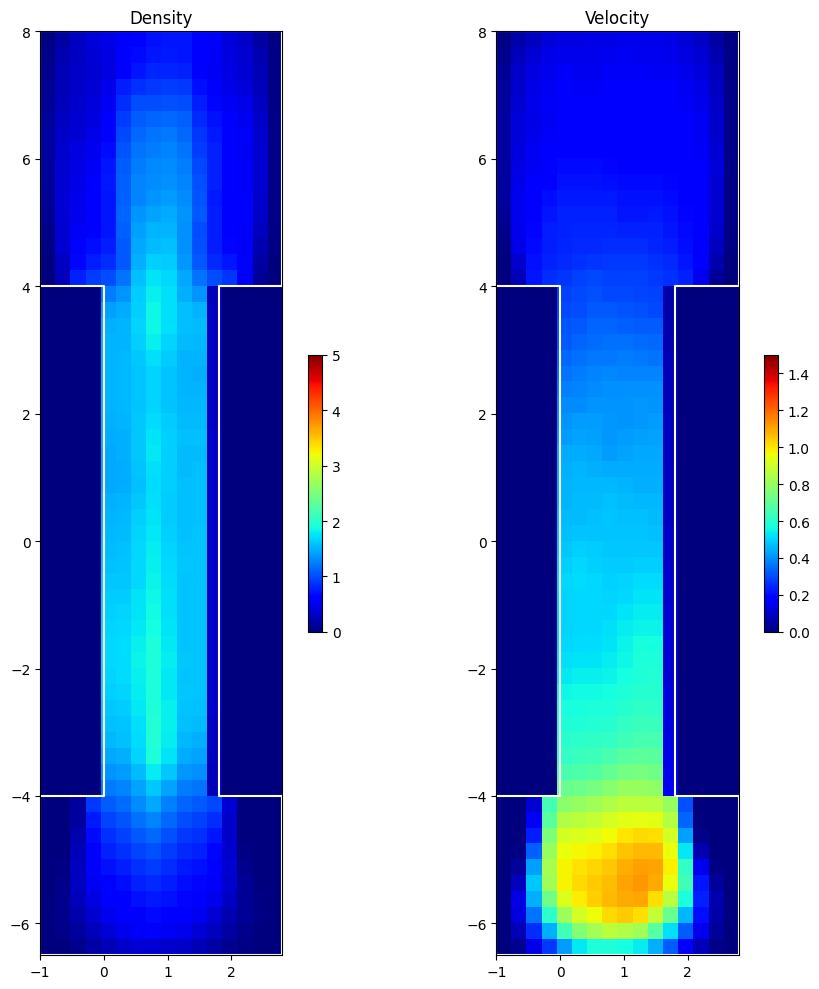

In [20]:
import matplotlib.pyplot as plt
import numpy as np

bounds = walkable_area.bounds

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

ax0.set_title("Density")
cm = ax0.imshow(
    np.mean(density_profiles, axis=0),
    extent=[bounds[0], bounds[2], bounds[1], bounds[3]],
    interpolation="None",
    cmap="jet",
    vmin=0,
    vmax=5,
)
fig.colorbar(cm, ax=ax0, shrink=0.3)
ax0.plot(*walkable_area.polygon.exterior.xy, color="w")

ax1.set_title("Velocity")
cm = ax1.imshow(
    np.mean(speed_profiles, axis=0),
    extent=[bounds[0], bounds[2], bounds[1], bounds[3]],
    interpolation="None",
    cmap="jet",
    vmin=0,
    vmax=1.5,
)
fig.colorbar(cm, ax=ax1, shrink=0.3)

ax1.plot(*walkable_area.polygon.exterior.xy, color="w")

fig.tight_layout()

# Plots

### Plot Voronoi cells

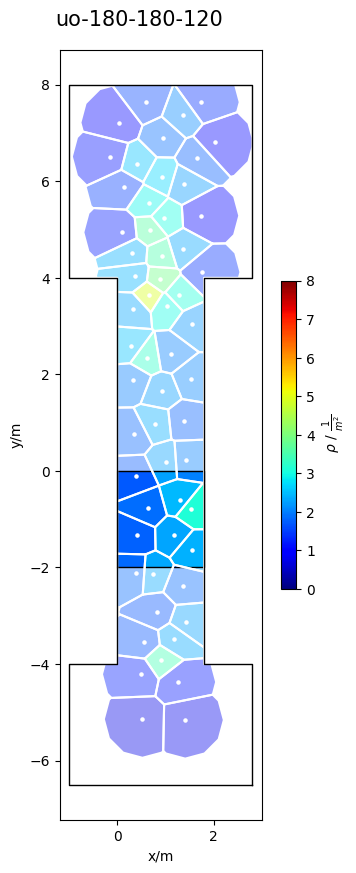

In [21]:
from pedpy import plot_voronoi_cells

# Choose trajectory file to plot
name = list(trajectories.keys())[7]

# Choose frame to plot
frame = 700

# Choose which color mode used to display the voronoi cells. Can be "density", "speed", or "id"
color_mode = "density"  # "speed" or "id"
vmin = 0
vmax = 8  # adapt when changing the color mode

# Choose which voronoi data to plot
use_cut_off_data = True

# merge all relevant data into one data frame
voronoi_data = (
    individual_cutoffs[name] if use_cut_off_data else individuals[name]
)
speed_data = (
    individual_speeds_cutoff[name][[ID_COL, FRAME_COL, SPEED_COL]]
    if use_cut_off_data
    else individual_speeds[name][[ID_COL, FRAME_COL, SPEED_COL]]
)
all_data = pd.merge(
    trajectories[name].data, voronoi_data, on=[ID_COL, FRAME_COL]
).merge(speed_data, on=[ID_COL, FRAME_COL])

data = all_data[all_data.frame == frame]

# Start plotting
fig = plt.figure(figsize=(5, 10))
fig.suptitle(name, y=0.92, fontsize=15)
ax1 = fig.add_subplot(111, aspect="equal")

ax1 = plot_voronoi_cells(
    data=data,
    walkable_area=walkable_area,
    measurement_area=measurement_area,
    color_mode=color_mode,
    vmin=vmin,
    vmax=vmax,
    show_ped_positions=True,
    ped_size=5,
    voronoi_outside_ma_alpha=0.4,
    ax=ax1,
)

plt.show()